---
title: Finite Difference
suptitle: Part I - Slicing
short_title: Finite Difference with Slicing Operations
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

**Jax Methods**

* Loops
* Scanning
* Convolutions
* Stencils

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import serket as sk
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

```{math}
:label: pde
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
```

For the PDE {eq}`pde`, we are going to do a forward difference discretization in space and a backwards in time. It is given by:

```{math}
:label: discretization_full
u_{i,j}^{n+1} = u_{i,j}^{n} - c \frac{\Delta t}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right)
```

Citation [cite](dot:10.1175/JTECH-D-20-0104.1).

In [3]:
# defime some variables
tmax = 10.0
nt = 1_000
a = 1
dt = tmax / nt
t0 = tmax / 2
time = np.linspace(0, tmax, nt)

def fn(time, t0, a):
    return (1 / np.sqrt(2 * np.pi * a)) * np.exp(- (((time - t0)**2) / (2 * a)))

def dfn(time, t0, a):
    return (-(time - t0)/a) * (1/np.sqrt(2*np.pi*a))*np.exp(-(time-t0)**2/(2*a))


In [4]:
f = fn(time, t0, a)
df = dfn(time, t0, a)

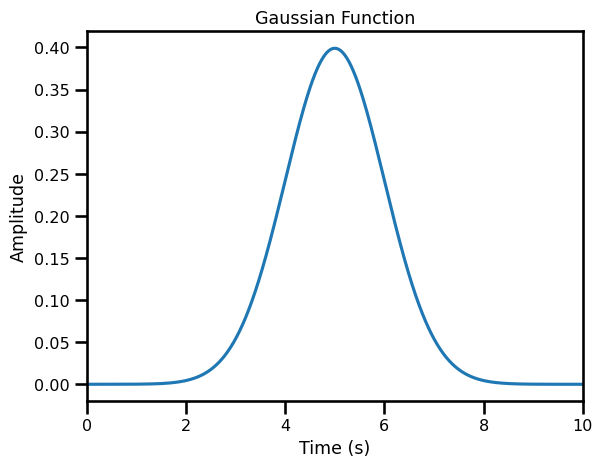

In [5]:
fig, ax = plt.subplots()
ax.plot(time, f)
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.show()

In [6]:
from jaxtyping import Array, Float

## Derivative Operators

Let's take some simple 1st order, first derivative formulations.

$$
\begin{aligned}
\mathcal{N}_\text{Forward}[u](x) &=  \frac{\partial u}{\partial x} \approx \frac{1}{\Delta x}(u_{i+1} + u_{i}) \\
\mathcal{N}_\text{Central}[u](x) &= \frac{\partial u}{\partial x} \approx \frac{1}{\Delta x}(\frac{1}{2}u_{i+1} - \frac{1}{2}u_{i-1}) \\
\mathcal{N}_\text{Backward}[u](x) &= \frac{\partial u}{\partial x} \approx \frac{1}{\Delta x}(u_i - u_{i-1}) \\
\end{aligned}
$$ (fd_schemes)



## Loops

I have to say, the easiest and clearest way to do this is the use loops! I think loops are readable and.

In [7]:
def diff_backward(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    
    un = np.zeros_like(u)
    for i in range(1, u.shape[0]):
        un[i] = (u[i] - u[i-1]) / dx
    return un

def diff_forward(u: Array, dx: float) -> Array:
    un = np.zeros_like(u)
    for i in range(0, u.shape[0]-1):
        un[i] = (u[i+1] - u[i]) / dx
    return un

def diff_central(u: Array, dx: float) -> Array:
    un = np.zeros_like(u)
    for i in range(1, u.shape[0]-1):
        un[i] = (0.5 * u[i+1] - 0.5 * u[i-1]) / dx
    return un

Unfortunately, python and loops is a bad idea...

In [8]:
solutions = dict()
solutions["loops"] = dict()

solutions["loops"]["forward"] = diff_forward(f, dt)
solutions["loops"]["backward"] = diff_backward(f, dt)
solutions["loops"]["central"] = diff_central(f, dt)

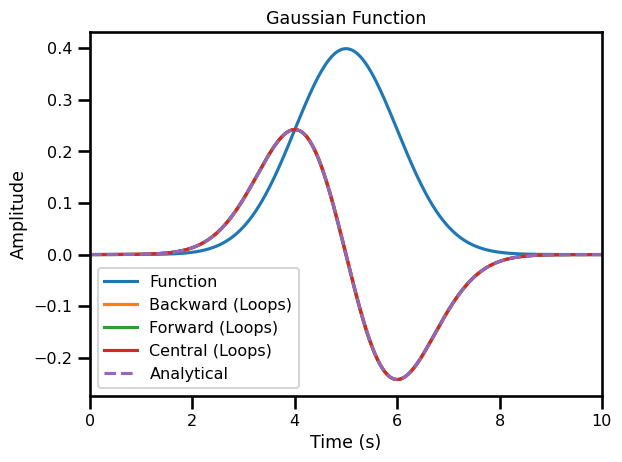

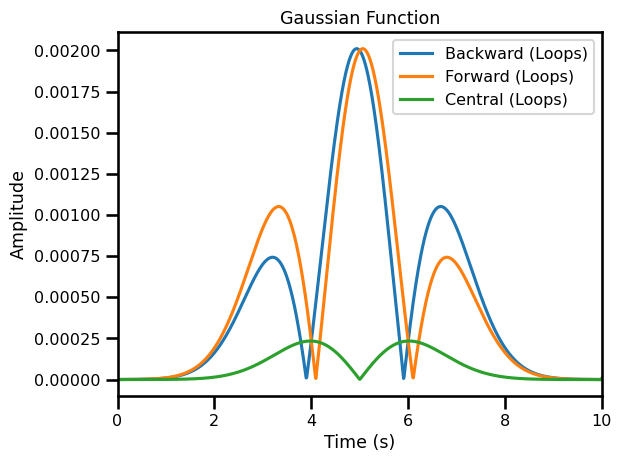

In [9]:
fig, ax = plt.subplots()
ax.plot(time, f, label="Function")
ax.plot(time, solutions["loops"]["backward"], label="Backward (Loops)")
ax.plot(time, solutions["loops"]["forward"], label=f"Forward (Loops)")
ax.plot(time, solutions["loops"]["central"], label=f"Central (Loops)")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(time, 
        np.abs(solutions["loops"]["backward"] - df), label="Backward (Loops)")
ax.plot(time, 
        np.abs(solutions["loops"]["forward"] - df), label="Forward (Loops)")
ax.plot(time, 
        np.abs(solutions["loops"]["central"] - df), label="Central (Loops)")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
from jaxdf.conv import fd_coefficients_fornberg

In [11]:
# import typing as tp

# def get_fd_coefficients(
#     accuracy: int=2, 
#     order: int=1,
#     stagger: tp.Union[float, int]=0,
#     return_nodes: bool=False
# ):
#     r"""Returnst the stencil coefficients for a 1D Finite Differences derivative
#     operator.
    
#     Args:
#       x: FiniteDifferences field
#       order: Order of the derivative
#       stagger: Stagger of the derivative
      
#     Returns:
#       Stencil coefficients
#     """
#     # get points
#     points = np.arange(-accuracy // 2, accuracy // 2 + 1)

#     # stagger correction
#     if stagger > 0:
#         points = (points + stagger)[:-1]
#     elif stagger < 0:
#         points = (points + stagger)[1:]

#     # get coefficients
#     coeffs, nodes = fd_coefficients_fornberg(order, points, x0=0)
#     coeffs = coeffs.tolist()
#     nodes = nodes.tolist()
    
#     print(nodes)

#     # append zero
#     if stagger > 0:
#         coeffs = coeffs + [0.0]
#     elif stagger < 0:
#         coeffs = [0.0] + coeffs
#     if return_nodes:
#         return np.asarray(coeffs), np.asarray(nodes)
#     else:
#         return np.asarray(coeffs)
    
# def fd_derivative_init(dx, axis: int=0, accuracy: int=2, stagger=0, padding: str="extend"):
    
#     ndim = len(dx)
#     # get kernel
#     kernel = get_fd_coefficients(accuracy=accuracy, order=1, stagger=stagger, return_nodes=False)
    
#     if ndim > 1:
#         for _ in range(ndim - 1):
#             kernel = rearrange(kernel, "... -> ... 1")
        
#         # move kernel to correct axis
#         kernel = np.moveaxis(kernel, -1, axis)
    
#     # add dx
#     kernel = kernel / dx[axis]
    
#     return kernel
    
# def fd_pad(kernel, accuracy, stagger):
#     def fd_pad(x):
#         return (
#             (x - int(np.floor(accuracy/2))) - 1 - stagger, #+ (order//2 - 1)
#             (x - int(np.ceil(accuracy/2))) - 1 + stagger,
#         )
#     pad = [fd_pad(x) for x in kernel.shape]
#     return pad

# from jax import scipy as jsp


# def fd_convolve(x, kernel, pad=None, mode: str="valid"):
    
#     kernel = jnp.flip(kernel, axis=tuple(range(kernel.ndim)))
    
#     return jsp.signal.convolve(x, kernel, mode="valid")

### Test Cases:



:::{note} 
:class: dropdown
**Central Difference (1D)**

| Nodes | Kernel | Pad |
|:-----:|:------:|:---:|
|`[-1, 0, 1]` | | `(1,1)`|
| `[-2, 1, 0, 1]` | | `(2,1)` |
| `[-2, 1, 0, 1, 2]` | |   `(2,2)` |
| `[-2, 1, 0, 1, 2]` | |  `(2,2)` |
| `[-3, -2 1, 0, 1, 2]` | |  `(3,2)`|
| `[-3, -2, 1, 0, 1, 2, 3]`| |  `(3,3)`|



:::

:::{note}
:class: dropdown

**Forward Difference (1D)**

| Nodes | Kernel | Pad |
|:-----:|:------:|:---:|
|`[-1, 0, 1]` | `[-1/2, 0, 1/2]` | `(1,1)`|
| `[-2, 1, 0, 1]` | | `(2,1)` |
| `[-2, 1, 0, 1, 2]` | |   `(2,2)` |
| `[-2, 1, 0, 1, 2]` | |  `(2,2)` |
| `[-3, -2 1, 0, 1, 2]` | |  `(3,2)`|
| `[-3, -2, 1, 0, 1, 2, 3]`| |  `(3,3)`|

:::



## Slicing

Looking at the finite difference schemes {eq}`fd_schemes`, we have many different ways of doing the same derivative depending upon the situation. But in any case, in python classes, we are often taught to use slicing! We grab the sections of the array that correspond to the 







**Current Method**:

In python, we are often taught to do this manually. So basically for every numerical scheme, we have a specific way to slice the array.

```python
# forward
x = (x[:-1] - x[1:]) / dx

```


In [12]:
def diff_back_1d(u: Array, dx: float) -> Array:
    # pad array
    u = jnp.pad(u, pad_width=((0,1)), mode="edge")
    return (u[1:] - u[:-1]) / dx

def diff_forward_1d(u: Array, dx: float) -> Array:
    # pad array
    u = jnp.pad(u, pad_width=((1,0)), mode="edge")
    return (u[1:] - u[:-1]) / dx

def diff_central_1d(u: Array, dx: float) -> Array:
    # pad array
    u = jnp.pad(u, pad_width=((1,1)), mode="edge", )
    return (u[2:] - u[:-2]) / ( 2 * dx )

### Padding

This is an artefact of the slicing operation. Because we take a subset of the array, we are inevitably left with a small dimensions as the original array. For example, for the second order, the forward and backwards difference approaches remove one dimension from the original array from the front and back respectively. The central difference removes a element from the front and back.



Some options include:

* "constant": this adds the same element
* "edge": 
* "linear_ramp": 

In [13]:
def diff_forward_slice(u: Array, dx: float) -> Array:
    # pad array
    u = jnp.pad(u, pad_width=((0,1)), mode="edge")
    return (u[1:] - u[:-1]) / dx

def diff_central_slice(u: Array, dx: float) -> Array:
    # pad array
    u = jnp.pad(u, pad_width=((1,1)), mode="edge", )
    return (u[2:] - u[:-2]) / ( 2 * dx )

def diff_backward_slice(u: Array, dx: float) -> Array:
    # pad array
    u = jnp.pad(u, pad_width=((1,0)), mode="edge")
    return (u[1:] - u[:-1]) / dx



In [14]:
solutions["slice"] = dict()

solutions["slice"]["forward"] = diff_forward_slice(f, dt)
solutions["slice"]["backward"] = diff_backward_slice(f, dt)
solutions["slice"]["central"] = diff_central_slice(f, dt)

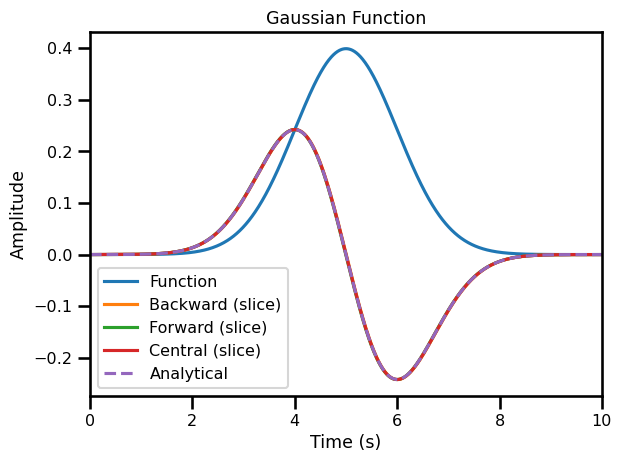

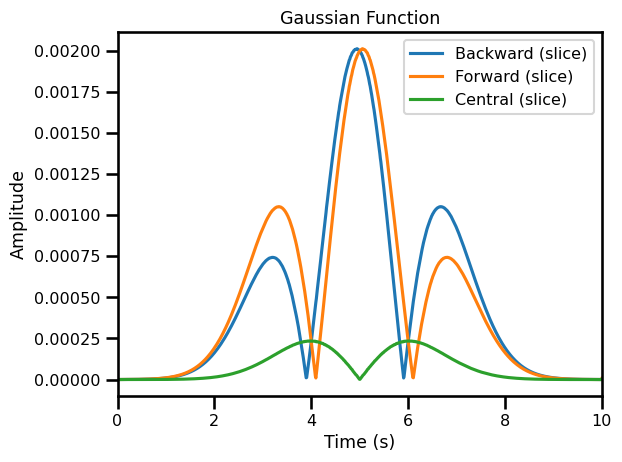

In [15]:
fig, ax = plt.subplots()
ax.plot(time, f, label="Function")
ax.plot(time, solutions["slice"]["backward"], label="Backward (slice)")
ax.plot(time, solutions["slice"]["forward"], label=f"Forward (slice)")
ax.plot(time, solutions["slice"]["central"], label=f"Central (slice)")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(time, 
        np.abs(solutions["slice"]["backward"] - df), label="Backward (slice)")
ax.plot(time, 
        np.abs(solutions["slice"]["forward"] - df), label="Forward (slice)")
ax.plot(time, 
        np.abs(solutions["slice"]["central"] - df), label="Central (slice)")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.tight_layout()
plt.show()

### Automating this

**Proposed Approach**:

```python
# calculate offsets
derivative: int = ...
accuracy: int = ...
method: str = "forward"
offsets: Tuple[int] = calculate_offsets(derivative, accuracy, method)

# calculate coefficients
coeffs: Tuple[float] = calculate_coefficients(offsets, derivative, method)

# calculate slices
x: Array = ...
slicer: Callable[Array] = calculate_slices(x, coeffs, method)

# do slicing
x: Array = slicer(x)
```

In [16]:
import finitediffx as fdx
# from jaxsw._src.operators.functional.fd import (
#     fd_forward_init, fd_central_init, fd_backward_init
# )
# from jaxsw._src.operators.functional.conv import fd_convolve
from jaxsw._src.operators.fd import Derivative

In [17]:
derivative = 1
accuracy = 2
axis = 0
dx = (dt,)

In [18]:
# get offsets
offsets = fdx._src.utils._generate_central_offsets(derivative=derivative, accuracy=accuracy)

print(f"Offsets: {offsets}")

Offsets: (-1, 0, 1)


This is consistent with the finite difference scheme ($-1 * a * u_{i-1} + 0 b * * u_i - 1 * c * u_{i-1}$). However, now we need to find the coefficients of this equation!

In [36]:


# get stencil
stencil = fdx._src.utils.generate_finitediff_coeffs(offsets, derivative=derivative)

print(f"Stencil: {stencil}")

Stencil: [-0.5  0.   0.5]


This is consistent with the proper finite difference scheme ($- 0.5 * u_{i-1} + 0 u_i - 0.5 * u_{i-1}$)

### Generate Slices

Now, we want to slice the array according to the stencil array. Recall how we typically slice an array in numpy. For example, the central difference method is sliced like

In [20]:
f_sliced = 0.5 * f[:-2] - 0.5 * f[2:]
f.shape, f_sliced.shape

((1000,), (998,))

Another way to do this is to create a "slice" object. In numpy we can call the `slice` function and define the bounds. Then we can directly input this into the array as if we were slicing.

In [21]:
f_sliced_obj = 0.5 * f[slice(0, 998)] - 0.5 * f[slice(2, 1000)]

np.testing.assert_array_equal(f_sliced, f_sliced_obj)

This can **quickly** get cumbersome very fast because we can do many different combinations of slicing depending upon 1) the finite difference scheme (forward, backward, central, upwind, etc), 2) the order of the scheme (1st, 2nd, 3rd, ...), and 3) the number of variables. Here is an example from the [12 Steps to Navier-Stokes tutorial](https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/10_Step_8.ipynb) where we have the u-term for the 1D Burgers equation

```python
u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     dt / dx * un[1:-1, 1:-1] * 
                     (un[1:-1, 1:-1] - un[1:-1, 0:-2]) - 
                     dt / dy * vn[1:-1, 1:-1] * 
                     (un[1:-1, 1:-1] - un[0:-2, 1:-1]) + 
                     nu * dt / dx**2 * 
                     (un[1:-1,2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) + 
                     nu * dt / dy**2 * 
                     (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))
```

If I were to give you the code (especially without explicitly stating the schemes), this is almost unreadable and it takes too much time to debug. In addition, it's easy to make mistakes. This is only 1D Burger's... Imagine Navier-Stokes with 3 dimensions and higher order schemes!

In general, this is the scheme for slicing an array.


$$
\text{Slice} := \text{Array}\left[\text{start}:\text{end}\right]
$$

So our objective is to find the *start* and *end* based on the stencil. Luckly, there is an easy way to do this which is generalizable.


In [51]:
derivative = 1
accuracy = 1
# get offsets
offsets = fdx._src.utils._generate_backward_offsets(derivative=derivative, accuracy=accuracy)

print(f"Offsets: {offsets}")

# get stencil
coeffs = fdx._src.utils.generate_finitediff_coeffs(offsets, derivative=derivative)

print(f"Stencil: {coeffs}")

Offsets: (-1, 0)
Stencil: [-1.  1.]


Let's say we are given the following offset:

````{tab-set}
```{tab-item} Central Difference

$$
\begin{aligned}
\text{offset} &:= (-1, 0, 1)
\end{aligned}
$$


```

```{tab-item} Forward Difference
$$
\begin{aligned}
\text{offset} &:= (0, 1, 2)
\end{aligned}
$$
```

```{tab-item} Backward Difference
$$
\begin{aligned}
\text{offset} &:= (-2, 1, 0)
\end{aligned}
$$
```

````

So given D elements in this stencil, we can write down the formula for a slice as:

$$
\text{Slice}_i := \text{Array}\left[\text{offset}_i - \text{offset}_0: D + (\text{offset}_i - \text{offset}_{n})\right]
$$

We can check this as well. So for all of the elements we have:

$$
\begin{aligned}
\text{Slice}_0 &:= \text{Array}\left[(-1) - (-1): D + ((-1) - (1))\right] = \text{Array}\left[0: \text{D}-2\right] \\
\text{Slice}_1 &:= \text{Array}\left[(0) - (-1): D + ((0) - (1))\right] = \text{Array}\left[1: \text{D} -1\right] \\
\text{Slice}_2 &:= \text{Array}\left[(1) - (-1): D + ((1) - (1))\right] = \text{Array}\left[2: \text{D}\right]
\end{aligned}
$$

Without the coefficients, this is consistent with how we normally do the slicing in python.


::::{tab-set}

:::{tab-item} Central Difference

```python
un = np.zeros_like(u)
for i in range(1, u.shape[0]-1):
    un[i] = (0.5 * u[i+1] - 0.5 * u[i-1]) / dx
```


```python
t1 = -0.5*u[:-2] + 0.0 * u[1:-1] + 0.5 * u[2:]
```

:::

:::{tab-item} Forward Difference

```python
un = np.zeros_like(u)
for i in range(1, u.shape[0]-1):
    un[i] = (0.0 * u[i-1] - u[i] + u[i+1] ) / dx
```

```python
u = u[1:] - u[:-1]
```
:::

:::{tab-item} Backward Difference

```python
un = np.zeros_like(u)
for i in range(1, u.shape[0]):
    un[i] = (u[i-1] - u[i] + 0.0 * u[i+1] ) / dx
```

```python
u = u[1:] - u[:-1]
```
:::

::::

### Test I: Central Difference Coefficients

In [54]:
derivative = 1
accuracy = 2
# get offsets
offsets = fdx._src.utils._generate_central_offsets(derivative=derivative, accuracy=accuracy)

print(f"Offsets: {offsets}")

# get stencil
coeffs = fdx._src.utils.generate_finitediff_coeffs(offsets, derivative=derivative)

print(f"Stencil: {coeffs}")

size = f.shape[axis]
# central difference
slices = []
for ioffset, icoeff in zip(offsets, coeffs):
    
    print(f"Raw: {icoeff} * slice({ioffset} - {offsets[0]}, {size} + ({ioffset} - {offsets[-1]})")
    print(f"Simplified: {icoeff} * slice({ioffset - offsets[0]}, {size + int(ioffset)-int(offsets[-1])}))\n")
    slices.append((slice(ioffset - offsets[0], size + (ioffset - offsets[-1]))))
    

# check that the slices are equal
np.testing.assert_array_equal(f[slices[0]], f[:-2])
np.testing.assert_array_equal(f[slices[1]], f[1:-1])
np.testing.assert_array_equal(f[slices[2]], f[2:])

Offsets: (-1, 0, 1)
Stencil: [-0.5  0.   0.5]
Raw: -0.5 * slice(-1 - -1, 1000 + (-1 - 1)
Simplified: -0.5 * slice(0, 998))

Raw: 0.0 * slice(0 - -1, 1000 + (0 - 1)
Simplified: 0.0 * slice(1, 999))

Raw: 0.5 * slice(1 - -1, 1000 + (1 - 1)
Simplified: 0.5 * slice(2, 1000))



### Test II: Forward Difference

In [64]:
derivative = 1
accuracy = 1
# get offsets
offsets = fdx._src.utils._generate_forward_offsets(derivative=derivative, accuracy=accuracy)

print(f"Offsets: {offsets}")

# get stencil
coeffs = fdx._src.utils.generate_finitediff_coeffs(offsets, derivative=derivative)

print(f"Stencil: {coeffs}")

size = f.shape[axis]
# central difference
slices = []
for ioffset, icoeff in zip(offsets, coeffs):
    
    print(f"Raw: {icoeff} * slice({ioffset} - {offsets[0]}, {size} + ({ioffset} - {offsets[-1]})")
    print(f"Simplified: {icoeff} * slice({ioffset - offsets[0]}, {size + int(ioffset)-int(offsets[-1])}))\n")
    slices.append((slice(ioffset - offsets[0], size + (ioffset - offsets[-1]))))
    

# check that the slices are equal
np.testing.assert_array_equal(f[slices[0]], f[:-1])
np.testing.assert_array_equal(f[slices[1]], f[1:])

Offsets: (0, 1)
Stencil: [-1.  1.]
Raw: -1.0 * slice(0 - 0, 1000 + (0 - 1)
Simplified: -1.0 * slice(0, 999))

Raw: 1.0 * slice(1 - 0, 1000 + (1 - 1)
Simplified: 1.0 * slice(1, 1000))



In [65]:
derivative = 1
accuracy = 1
# get offsets
offsets = fdx._src.utils._generate_backward_offsets(derivative=derivative, accuracy=accuracy)

print(f"Offsets: {offsets}")

# get stencil
coeffs = fdx._src.utils.generate_finitediff_coeffs(offsets, derivative=derivative)

print(f"Stencil: {coeffs}")

size = f.shape[axis]
# central difference
slices = []
for ioffset, icoeff in zip(offsets, coeffs):
    
    print(f"Raw: {icoeff} * slice({ioffset} - {offsets[0]}, {size} + ({ioffset} - {offsets[-1]})")
    print(f"Simplified: {icoeff} * slice({ioffset - offsets[0]}, {size + int(ioffset)-int(offsets[-1])}))\n")
    slices.append((slice(ioffset - offsets[0], size + (ioffset - offsets[-1]))))
    

# check that the slices are equal
np.testing.assert_array_equal(f[slices[0]], f[:-1])
np.testing.assert_array_equal(f[slices[1]], f[1:])

Offsets: (-1, 0)
Stencil: [-1.  1.]
Raw: -1.0 * slice(-1 - -1, 1000 + (-1 - 0)
Simplified: -1.0 * slice(0, 999))

Raw: 1.0 * slice(0 - -1, 1000 + (0 - 0)
Simplified: 1.0 * slice(1, 1000))



#### Jax Tip: Dynamic Slicing

In JAX, this is even easier. We can use the `slice_in_dim` function which allows us to dynamically slice an existing array. So instead of generating the `slice` object and then indexing a numpy array, we can define a function which allows us to dynamically slice the array directly.

In [24]:
# numpy
slice_i = slice(0, 998)
demo_np = f[slice_i]
# jax
demo_jax = jax.lax.slice_in_dim(f, 0, 998, axis=0)

np.testing.assert_array_almost_equal(demo_np, demo_jax)

In [25]:
import functools as ft

# initialize slice object
size = f.shape[axis]
axis = 0

sliced = ft.partial(jax.lax.slice_in_dim, f, axis=axis)

# slice the objects
f_sliced = sum(
    coeff * sliced(offset - offsets[0], size + (offset - offsets[-1]))
    for offset, coeff in zip(offsets, stencil)
)

# check the solution is the same
np.testing.assert_array_almost_equal(f_sliced/dx[0], solutions["slice"]["central"][1:-1])

## Padding

Of course we cannot go through this without discussing padding... Slicing using the central difference of order 2 will produce an `Array` with 2 dimensions less than the original `Array`. So as mentioned before, we have two options:

1. Only update the portions of the array that is sliced.
2. Pad the array such that the slicing produces an array of the same size.

In [26]:
from jaxsw._src.operators.functional.padding import (
    generate_central_padding, 
    generate_forward_padding,
    generate_backward_padding
)

## Altogether

In [26]:
from jaxsw._src.operators.functional.padding import (
    generate_central_padding, 
    generate_forward_padding,
    generate_backward_padding
)

In [79]:
derivative = 1
accuracy = 2
method = "central"

# generate offsets
offsets = fd.generate_central_offsets(derivative=derivative, accuracy=accuracy)

# generate coefficients
coeffs = fd.generate_finitediff_coeffs(offsets=offsets, derivative=derivative)

# generate padding
padding = generate_central_padding(derivative=derivative, accuracy=accuracy)

print(f"Offsets: {offsets}")
print(f"Coeffs: {coeffs}")
print(f"Padding: {padding}")

step_size = dx[0]
axis = 0
mode = "edge"

x = fd.central_difference(
    f, derivative=derivative,
    step_size=step_size, axis=axis, 
    coeffs=coeffs, offsets=offsets,
    padding=padding, 
    mode="edge"
)
x.shape, f.shape

Offsets: (-1, 0, 1)
Coeffs: [-0.5  0.   0.5]
Padding: (1, 1)
(1002,) [-0.5  0.   0.5] (-1, 0, 1)
0 1000


((1000,), (1000,))

In [80]:
solutions["slice_auto"] = dict()

solutions["slice_auto"]["central"] = diff_central_slice(f, dt)

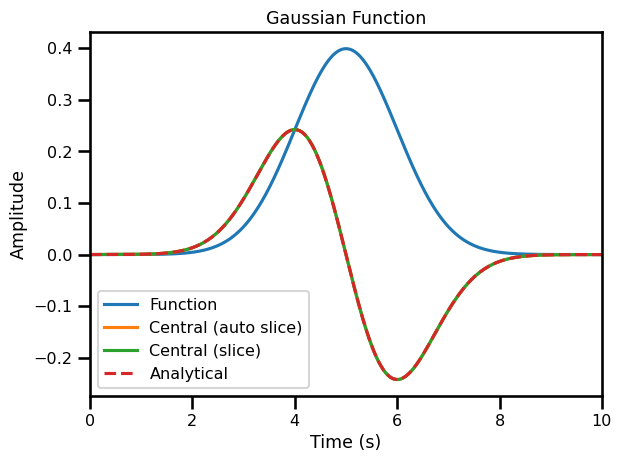

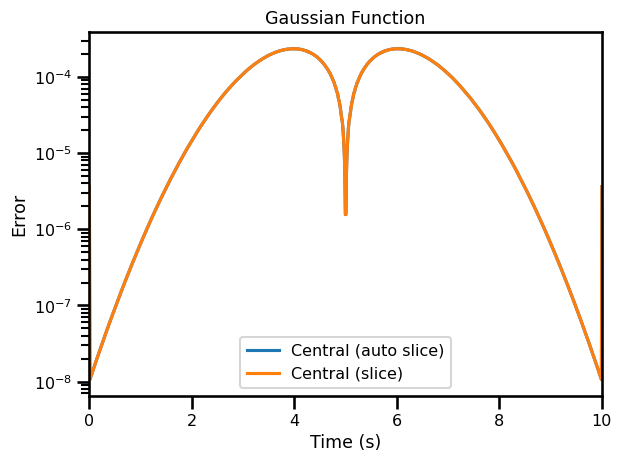

In [81]:
fig, ax = plt.subplots()
ax.plot(time, f, label="Function")
ax.plot(time, solutions["slice_auto"]["central"], label=f"Central (auto slice)")
ax.plot(time, solutions["slice"]["central"], label=f"Central (slice)")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(time, 
        np.abs(solutions["slice_auto"]["central"] - df), label="Central (auto slice)")
ax.plot(time, 
        np.abs(solutions["slice"]["central"] - df), label="Central (slice)")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Error",
    xlim=(0,tmax),
    yscale="log",
)
plt.legend()
plt.tight_layout()
plt.show()

In [82]:
# def fd_convolve(
#     x: Array, 
#     kernel: Array, 
#     pad: tp.Optional[Array]=None, mode: str="edge") -> Array:
    
#     if pad is not None:
#         x = jnp.pad(x, pad_width=pad, mode=mode)
    
#     kernel = jnp.flip(kernel, axis=tuple(range(kernel.ndim)))
    
#     return jsp.signal.convolve(x, kernel, mode="valid")

## Object Operators

In [83]:
from jaxsw._src.operators.fd import Derivative

In [86]:
solutions["slice_auto"] = dict()

dx = (dt,)
axis = 0
accuracy = 2
derivative = 1
mode = "edge"
method = "central"

operator = Derivative(
    dx=dx, 
    axis=axis,
    accuracy=accuracy,
    derivative=derivative,
    mode=mode,
    method=method
)


solutions["slice_auto"]["central"] = operator(f)
np.testing.assert_array_equal(solutions["slice_auto"]["central"], solutions["slice"]["central"])

# BACKWARDS
dx = (dt,)
axis = 0
accuracy = 1
derivative = 1
mode = "edge"
method = "backward"

operator = Derivative(
    dx=dx, 
    axis=axis,
    accuracy=accuracy,
    derivative=derivative,
    mode=mode,
    method=method
)


solutions["slice_auto"]["backward"] = operator(f)

np.testing.assert_array_equal(solutions["slice_auto"]["backward"], solutions["slice"]["backward"])

# FORWARD
dx = (dt,)
axis = 0
accuracy = 1
derivative = 1
mode = "edge"
method = "forward"

operator = Derivative(
    dx=dx, 
    axis=axis,
    accuracy=accuracy,
    derivative=derivative,
    mode=mode,
    method=method
)


solutions["slice_auto"]["forward"] = operator(f)

np.testing.assert_array_equal(solutions["slice_auto"]["forward"], solutions["slice"]["forward"])

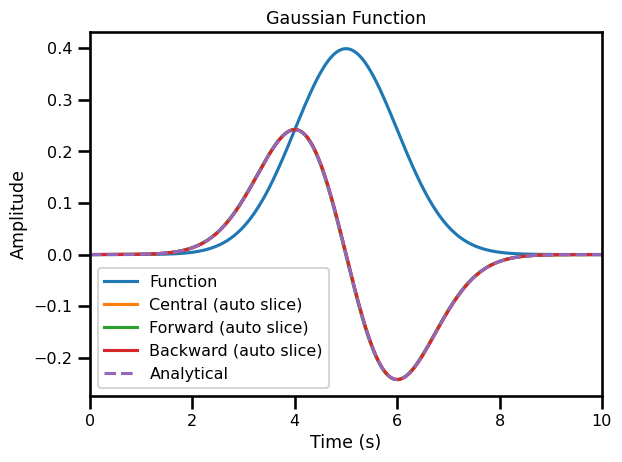

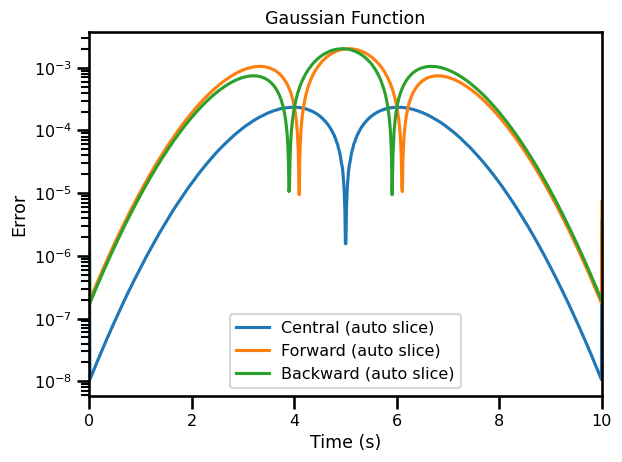

In [87]:
fig, ax = plt.subplots()
ax.plot(time, f, label="Function")
ax.plot(time, solutions["slice_auto"]["central"], label=f"Central (auto slice)")
ax.plot(time, solutions["slice_auto"]["forward"], label=f"Forward (auto slice)")
ax.plot(time, solutions["slice_auto"]["backward"], label=f"Backward (auto slice)")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(time, 
        np.abs(solutions["slice_auto"]["central"] - df), label="Central (auto slice)")
ax.plot(time, 
        np.abs(solutions["slice_auto"]["forward"] - df), label="Forward (auto slice)")
ax.plot(time, 
        np.abs(solutions["slice_auto"]["backward"] - df), label="Backward (auto slice)")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Error",
    xlim=(0,tmax),
    yscale="log",
)
plt.legend()
plt.tight_layout()
plt.show()

In [89]:
solutions["slice_auto"] = dict()

dx = (dt,)
axis = 0
accuracy = 8
derivative = 1
mode = "edge"
method = "central"

operator = Derivative(
    dx=dx, 
    axis=axis,
    accuracy=accuracy,
    derivative=derivative,
    mode=mode,
    method=method
)


solutions["slice_auto"]["central"] = operator(f)

# BACKWARDS
dx = (dt,)
axis = 0
accuracy = 8
derivative = 1
mode = "edge"
method = "backward"

operator = Derivative(
    dx=dx, 
    axis=axis,
    accuracy=accuracy,
    derivative=derivative,
    mode=mode,
    method=method
)


solutions["slice_auto"]["backward"] = operator(f)


# FORWARD
dx = (dt,)
axis = 0
accuracy = 8
derivative = 1
mode = "edge"
method = "forward"

operator = Derivative(
    dx=dx, 
    axis=axis,
    accuracy=accuracy,
    derivative=derivative,
    mode=mode,
    method=method
)


solutions["slice_auto"]["forward"] = operator(f)


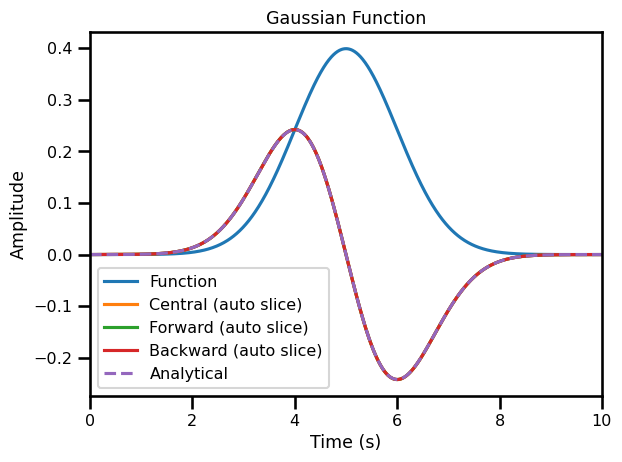

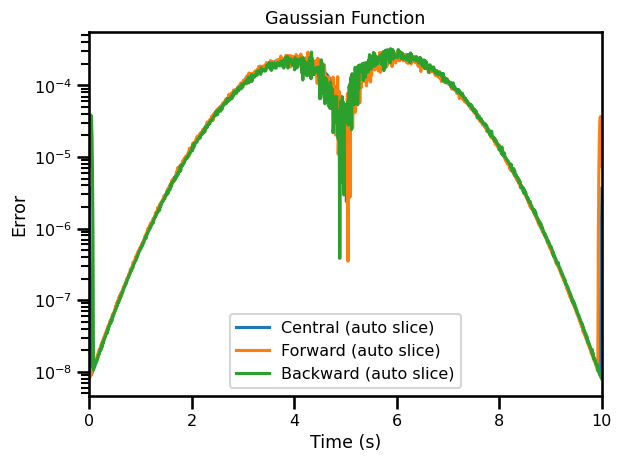

In [90]:
fig, ax = plt.subplots()
ax.plot(time, f, label="Function")
ax.plot(time, solutions["slice_auto"]["central"], label=f"Central (auto slice)")
ax.plot(time, solutions["slice_auto"]["forward"], label=f"Forward (auto slice)")
ax.plot(time, solutions["slice_auto"]["backward"], label=f"Backward (auto slice)")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(time, 
        np.abs(solutions["slice_auto"]["central"] - df), label="Central (auto slice)")
ax.plot(time, 
        np.abs(solutions["slice_auto"]["forward"] - df), label="Forward (auto slice)")
ax.plot(time, 
        np.abs(solutions["slice_auto"]["backward"] - df), label="Backward (auto slice)")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Error",
    xlim=(0,tmax),
    yscale="log",
)
plt.legend()
plt.tight_layout()
plt.show()